## Aluno: João Pedro Regazzi Ferreira da Silva
## DRE: 120030115


### Para comparar os 5 métodos de clustering, serão, primeiramente, construídos dados fictícios para testes.



In [72]:
%matplotlib inline
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

Automatically created module for IPython interactive environment


# 1) Método K-means Clustering
Este tipo de algoritmo utiliza de iterações para tentar particionar os dados em K subgrupos sem intersecção. Na tentativa de manter dados de um mesmo grupo o mais parecidos possíveis, preservando a distinção entre *clusters*, são gerados centroides até que os grupos não se alterem. Pontos de dados são inseridos no grupo do centroide mais próximo a eles. A alteração da posição dos centroides é determinada pela posição média de todos os pontos de dados de uma mesma associação.


Dessa forma, este Método de associação é altamente implementado pela indústria para segmentação de mercado. O perfil de possíveis clientes são inspecionados para tentar prever o que é mais provável de ser comprado futuramente. Associação de documentos e partição de imagens também são aplicações comuns deste famoso algoritmo.

Os testes realizados a seguir exprimem resultados nada satisfátórios, visto que os dados não são de casos mais recomendados para a aplicação do algoritmo *K-means*.

## Exemplo de funcionamento

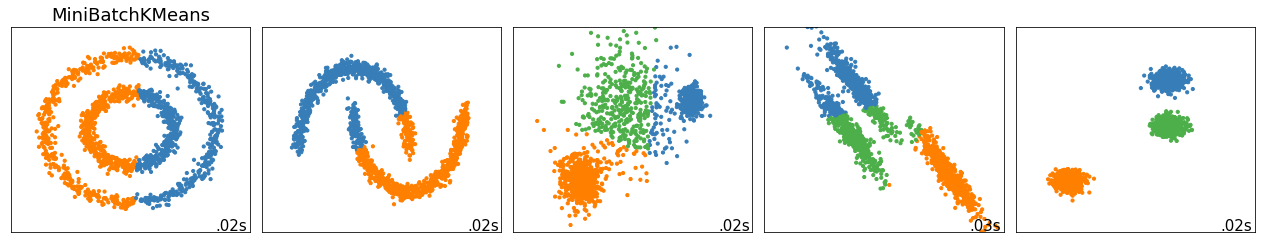

In [73]:
# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(18, 15))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])

    name = 'MiniBatchKMeans'
    algorithm = two_means
    t0 = time.time()

    # catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the " +
            "connectivity matrix is [0-9]{1,2}" +
            " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding" +
            " may not work as expected.",
            category=UserWarning)
        algorithm.fit(X)

    t1 = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X)

    plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
    if i_dataset == 0:
        plt.title(name, size=18)

    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                          '#f781bf', '#a65628', '#984ea3',
                                          '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
    # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
              transform=plt.gca().transAxes, size=15,
              horizontalalignment='right')
    plot_num += 1

plt.show()

# 2) DBSCAN
O método DBSAN, do inglês, *Density-based spatial clustering of applications*, geralmente apresenta resultados melhores e mais rápidos que o K-means. Este algoritmo se baseia na densidade dos grupos, sendo necessária a definição da distância máxima entre um ponto e seu vizinho mais próximo de seu mesmo *cluster*.

Inicialmente, um ponto aleatório é selecionado e todos os pontos dentro de uma distância máxima são inseridos em um mesmo *cluster*. Em seguida, o ponto mais próximo ao original é selecionado e o processo se repete. Isto ocorre até que todos os pontos possíveis são alcançados. Neste momento, se houver algum ponto sem grupo, ele é escolhido para recomeçar o algoritmo. Com isso, todos os dados são associados em *clusters* e o sistema é finalizado.

O DBSCAN pode ser implementado como um substituto do K-means em diversas situações e , portanto, também pode ser utilizado para segmentação de mercado. Nos exemplos de teste deste trabalho o DBSCAN apresentou resultados superiores quando comparado ao *K-means*.


## Exemplo de funcionamento

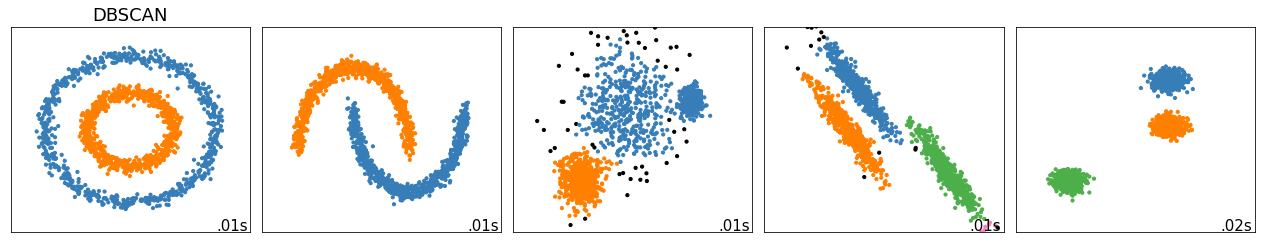

In [74]:
# ============
# Set up cluster parameters
plt.figure(figsize=(18, 15))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1


for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    dbscan = cluster.DBSCAN(eps=params['eps'])

    name = 'DBSCAN'
    algorithm = dbscan
    t0 = time.time()

    # catch warnings related to kneighbors_graph 
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the " +
            "connectivity matrix is [0-9]{1,2}" +
            " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding" +
            " may not work as expected.",
            category=UserWarning)
        algorithm.fit(X)

    t1 = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X)

    plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
    if i_dataset == 0:
        plt.title(name, size=18)

    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                          '#f781bf', '#a65628', '#984ea3',
                                          '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
    # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
              transform=plt.gca().transAxes, size=15,
              horizontalalignment='right')
    plot_num += 1

plt.show()

# 3) Método Spectral Clustering
Para realização de um algoritmo *spectral clustering* são efetuados três passos básicos, que serão apresentados a seguir:

1- Pré-processamento dos dados é feito a partir da representação da informação em matrizes. Nesse sentido, os pontos de dados são escritos de forma matricial.

2- Decomposição da matriz a partir do cálculo dos autovalores e autovetores da mesma. Todos os pontos são mapeados em dimensões menores da original a partir de pelo menos um autovetor.

3-Agrupamento dos pontos é efetuado, podendo ser realizado de diversas maneiras. Algumas formas de agrupar os pontos são mais rápidas do que outras, porém podem trabalhar de maneira ingênua.

Este método é comumente implementado para partição de imagens gráficas e segmentação de áudios de voz. Vale ressaltar que, nos casos testados, o tempo de processamento foi superior em comparação ao do K-means e ao do DBSCAN. Os resultados foram ainda mais satisfátorios do que os do DBSCAN.

## Exemplo de funcionamento

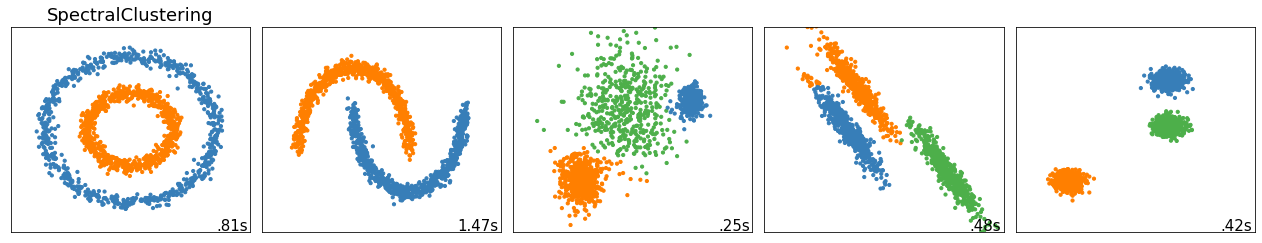

In [75]:
# ============
# Set up cluster parameters
plt.figure(figsize=(18, 15))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])

    name = 'SpectralClustering'
    algorithm = spectral
    t0 = time.time()

    # catch warnings related to kneighbors_graph 
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the " +
            "connectivity matrix is [0-9]{1,2}" +
            " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding" +
            " may not work as expected.",
            category=UserWarning)
        algorithm.fit(X)

    t1 = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X)

    plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
    if i_dataset == 0:
        plt.title(name, size=18)

    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                          '#f781bf', '#a65628', '#984ea3',
                                          '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
    # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
              transform=plt.gca().transAxes, size=15,
              horizontalalignment='right')
    plot_num += 1

plt.show()

# 4) Método Affinity Propagation
Este método utiliza do conceito de "passar a mensagem" entre dois pontos de dados. Diferentemente do *K-means* ele não necessita que o número de *clusters* seja determinado de antemão. A propagação por afinidade se basea em quatro matrizes para funcionar:

-A matriz de similaridade possui valores que indicam quão semelhantes dois pontos são. Na sua diagonal estão os menores números da matriz.

-A matriz de responsabilidade é constituida por valores que representam as relações de responsabilidade entre os dados.

-A matriz de disponibilidade apresenta a quantificação numérica da disponibilidade de um objeto ser um exemplar de outro.

-Por fim, a matriz de critério possui em suas células a soma simples da disponibilidade com a responsabilidade na posição equivalente das matrizes anteriores.

A propagação por afinidade é um algoritmo importantíssimo para a computação pois, embora tenha apresentado os piores resultados de tempo e agrupamento nos testes, o desenvolvimento de visão computacional é fortemente beneficiado pela implementação deste método.

## Exemplo de funcionamento

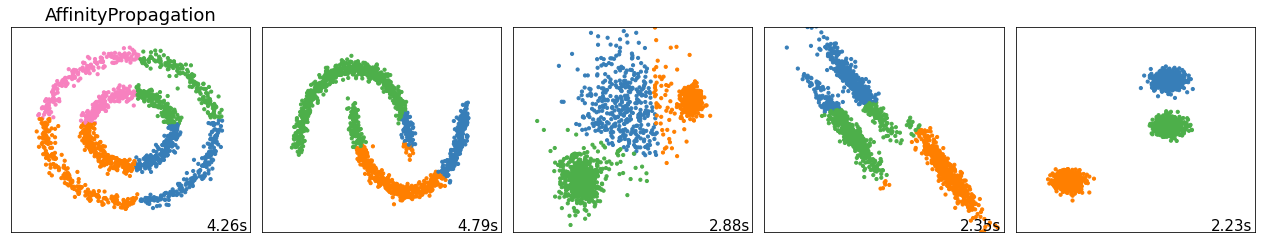

In [76]:
# ============
# Set up cluster parameters
plt.figure(figsize=(18, 15))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])

    name = 'AffinityPropagation'
    algorithm = affinity_propagation
    t0 = time.time()

    # catch warnings related to kneighbors_graph 
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the " +
            "connectivity matrix is [0-9]{1,2}" +
            " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding" +
            " may not work as expected.",
            category=UserWarning)
        algorithm.fit(X)

    t1 = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X)

    plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
    if i_dataset == 0:
        plt.title(name, size=18)

    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                          '#f781bf', '#a65628', '#984ea3',
                                          '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
    # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
              transform=plt.gca().transAxes, size=15,
              horizontalalignment='right')
    plot_num += 1

plt.show()

# 5) Método Mean Shift
Muito aplicado em processamento de imagens e visão computacional, o *Mean Shift* busca picos de densidade de dados para realizar as associações.

Primeiramente, pontos aleatoriórios são selecionados e, considerando determinado raio de distância máxima, o círculo, anteriormente centrado no ponto escolhido, é transferido para o ponto médio de todos os dados que estavam em seu interior. Este processo é feito até que o círculo pare de se alterar. Quando todos os dados estão inseridos em algum grupo, o algoritmo chega ao fim. Por se iniciar em pontos aleatórios, rodar novamente o *Mean Shift* pode significar obter associações diferentes dos dados.

Analisando os testes, percebemos que o *Mean Shift* apresentou resultados inferiores em relação ao *K-Means*, ao *DBSCAN* e ao *Spectral Clustering*.

# Exemplo de funcionamento

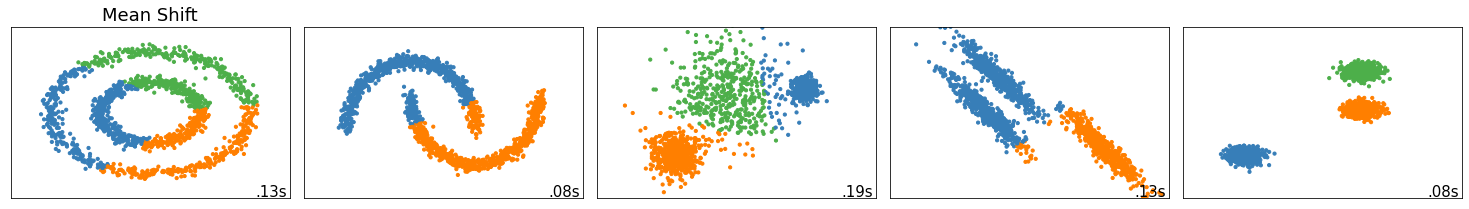

In [77]:
# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)

    name = 'Mean Shift'
    algorithm = ms
    t0 = time.time()

    # catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the " +
            "connectivity matrix is [0-9]{1,2}" +
            " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding" +
            " may not work as expected.",
            category=UserWarning)
        algorithm.fit(X)

    t1 = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X)

    plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
    if i_dataset == 0:
        plt.title(name, size=18)

    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                          '#f781bf', '#a65628', '#984ea3',
                                          '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
    # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
              transform=plt.gca().transAxes, size=15,
              horizontalalignment='right')
    plot_num += 1

plt.show()